In [2]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import MinMaxScaler

np.random.seed(29)


/tmp/ipykernel_10918/3670510855.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# Scales each feature to lie in [0, 1] and separate the data into training and
# test sets.

def preprocess_data(X, y):
    scaler = MinMaxScaler(feature_range=(0, 1))
    X = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
    return [X_train, X_test, y_train, y_test]
    

In [94]:
dataset_names = ['wdbc', 'arrhythmia', 'darwin']
dataset_arrays = []

wdbc_data = pd.read_csv('/mnt/c/Users/joshi/USC/csci567-project/breast+cancer+wisconsin+diagnostic/wdbc.data', header=None).to_numpy()
wdbc_X = wdbc_data[:, 2:31]
wdbc_y = wdbc_data[:, 1]
wdbc_processed_data = preprocess_data(wdbc_X, wdbc_y)
dataset_arrays.append(wdbc_processed_data)


arrythmia_data = pd.read_csv('/mnt/c/Users/joshi/USC/csci567-project/arrhythmia/arrhythmia.data', header=None).replace('?', np.nan).to_numpy()
# Fills in missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
arrythmia_data = imputer.fit_transform(arrythmia_data)
arrythmia_X = arrythmia_data[:, 0:278]
arrythmia_y = arrythmia_data[:, 279]
arrythmia_processed_data = preprocess_data(arrythmia_X, arrythmia_y)
dataset_arrays.append(arrythmia_processed_data)

# Returns the dataset with given name
def get_dataset(name):
    i = dataset_names.index(name)
    return dataset_arrays[i]

In [49]:
print(wdbc_X)
print(type(wdbc_X))
print(wdbc_y)
print(type(wdbc_y))

[[17.99 10.38 122.8 ... 0.7119 0.2654 0.4601]
 [20.57 17.77 132.9 ... 0.2416 0.186 0.275]
 [19.69 21.25 130.0 ... 0.4504 0.243 0.3613]
 ...
 [16.6 28.08 108.3 ... 0.3403 0.1418 0.2218]
 [20.6 29.33 140.1 ... 0.9387 0.265 0.4087]
 [7.76 24.54 47.92 ... 0.0 0.0 0.2871]]
<class 'numpy.ndarray'>
['M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'
 'M' 'B' 'B' 'B' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'
 'M' 'B' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'B' 'M' 'B' 'B' 'B' 'B' 'B' 'M'
 'M' 'B' 'M' 'M' 'B' 'B' 'B' 'B' 'M' 'B' 'M' 'M' 'B' 'B' 'B' 'B' 'M' 'B'
 'M' 'M' 'B' 'M' 'B' 'M' 'M' 'B' 'B' 'B' 'M' 'M' 'B' 'M' 'M' 'M' 'B' 'B'
 'B' 'M' 'B' 'B' 'M' 'M' 'B' 'B' 'B' 'M' 'M' 'B' 'B' 'B' 'B' 'M' 'B' 'B'
 'M' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'M' 'M' 'M' 'B' 'M' 'M' 'B' 'B' 'B'
 'M' 'M' 'B' 'M' 'B' 'M' 'M' 'B' 'M' 'M' 'B' 'B' 'M' 'B' 'B' 'M' 'B' 'B'
 'B' 'B' 'M' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'M' 'B' 'B' 'B' 'B' 'M'
 'M' 'B' 'M' 'B' 'B' 'M' 'M' 'B' 'B' 'M' 'M' 'B' '

## [DARWIN dataset exploration](https://archive.ics.uci.edu/dataset/732/darwin)

### Read in the dataset and get the y values/class labels

In [63]:
darwin_data = pd.read_csv('/mnt/c/Users/joshi/USC/csci567-project/DARWIN/DARWIN.csv', header=0)
#Get y data
darwin_y = np.array(darwin_data.iloc[:,len(darwin_data.columns)-1])
print(len(darwin_y))
print(f"{type(darwin_y)}\n{darwin_y}")

174
<class 'numpy.ndarray'>
['P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P'
 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P'
 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P'
 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P'
 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'H'
 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H'
 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H'
 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H'
 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H'
 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H']


In [58]:
print(len(darwin_data.columns))

452


### X data features

In [60]:
darwin_X = np.array(darwin_data.iloc[:,1:len(darwin_data.columns)-1]) #Last column is the class label
print(f"{type(darwin_X)}\n{darwin_X}")
print(darwin_X.shape)

<class 'numpy.ndarray'>
[[5.16000000e+03 1.25000000e-05 1.20804174e+02 ... 1.74927817e+03
  2.96102768e+05 1.44605000e+05]
 [5.19800000e+04 1.60000000e-05 1.15318238e+02 ... 1.50476827e+03
  2.78744285e+05 2.98640000e+05]
 [2.60000000e+03 1.03000000e-05 2.29933997e+02 ... 1.43144349e+03
  1.44411706e+05 7.90250000e+04]
 ...
 [3.83000000e+03 8.36000000e-06 1.51536989e+02 ... 1.91557349e+03
  1.28727124e+05 8.34450000e+04]
 [1.76000000e+03 7.96000000e-06 2.89518195e+02 ... 1.91557349e+03
  1.28727124e+05 8.34450000e+04]
 [2.87500000e+03 8.18000000e-06 2.35769350e+02 ... 1.91557349e+03
  1.28727124e+05 8.34450000e+04]]
(174, 450)


### Split the data into training and test sets

In [65]:
darwin_data_split = preprocess_data(darwin_X, darwin_y)
darwin_data_x_train = darwin_data_split[0]
darwin_data_x_test = darwin_data_split[1]
darwin_data_y_train = darwin_data_split[2]
darwin_data_y_test = darwin_data_split[3]

In [66]:
dataset_arrays.append(darwin_data_split)

## Helper Functions to 
- train and evaluate a model using Bagging Classifier ontop of logistic regression
- Plot accuracy curves vs number of estimators
- Plot accuracy curves vs number of max_samples (fraction of)
- Plot accuracy curves vs C regularization parameter (inverse of regularization strength)

In [69]:
# Trains bagging model on top of logistic regression.
def bagging_log_regr(X_train, X_test, y_train, y_test, num_models, frac_samples, regularization=None):
    if (regularization == None):
        base = LogisticRegression(penalty=None, max_iter=5000)
    else:
        base = LogisticRegression(penalty='l2', C=regularization, max_iter=5000)
    bagging_classifier = BaggingClassifier(estimator=base, 
                                           n_estimators=num_models, 
                                           max_samples=frac_samples)
    bagging_classifier.fit(X_train, y_train)
    return bagging_classifier.score(X_train, y_train), bagging_classifier.score(X_test, y_test)

# Plots training and testing accuracy vs. number of base learners.
def plot_acc_vs_n_models(list_n_models, list_tr_acc, list_te_acc, nobag_tr_acc, nobag_te_acc):
    plt.plot(list_n_models, list_tr_acc, label='Train')
    plt.plot(list_n_models, list_te_acc, label='Test')
    nobag_tr = np.full(len(list_n_models), nobag_tr_acc)
    nobag_te = np.full(len(list_n_models), nobag_te_acc)
    plt.plot(list_n_models, nobag_tr, label='Train without bagging')
    plt.plot(list_n_models, nobag_te, label='Test without bagging')
    plt.legend(loc='best')
    plt.show()
    

In [81]:
# Plots training and test accuracies vs number of examples used to train each base learners.
def plot_acc_vs_n_examples(list_n_examples, list_tr_acc, list_te_acc, nobag_tr_acc, nobag_te_acc):
    plt.plot(list_n_examples, list_tr_acc, label='Train')
    plt.plot(list_n_examples, list_te_acc, label='Test')
    nobag_tr = np.full(len(list_n_examples), nobag_tr_acc)
    nobag_te = np.full(len(list_n_examples), nobag_te_acc)
    plt.plot(list_n_examples, nobag_tr, label='Train without bagging')
    plt.plot(list_n_examples, nobag_te, label='Test without bagging')
    plt.legend(loc='best')
    plt.show()

In [82]:
# Plots training and test accuracies vs C (inverse of regularization strength)
def plot_acc_vs_C(list_C, list_tr_acc, list_te_acc, list_nobag_tr_acc, list_nobag_te_acc):
    plt.plot(list_C, list_tr_acc, label='Train w/ bagging')
    plt.plot(list_C, list_te_acc, label='Test w/ bagging')
    plt.plot(list_C, list_nobag_tr_acc, label='Train w/o bagging')
    plt.plot(list_C, list_nobag_te_acc, label='Test w/o bagging')
    plt.legend(loc='best')
    plt.show()

## List of Hyperparameters to tune/test for each experiment

In [85]:
list_n_models = [1, 5, 10, 20, 50, 100, 200] #Number of base learners
list_n_examples = [0.1, 0.3, 0.5, 0.7, 0.9] #Fractional max_samples
list_C = [0.1, 0.5, 1, 5, 10, 50, 100, 500] #Regularization parameter

## WDBC Dataset Experiments

### Base learners (n_estimators)

In [93]:
# Test on number of base learners

X_train, X_test, y_train, y_test = get_dataset('wdbc')

log_regr = LogisticRegression(penalty=None, max_iter=5000)
log_regr.fit(X_train, y_train)
nobag_tr_acc = log_regr.score(X_train, y_train)
nobag_te_acc = log_regr.score(X_test, y_test)
print(nobag_tr_acc)
print(nobag_te_acc)


list_tr_acc = []
list_te_acc = []
for n_models in list_n_models:
    tr_acc, te_acc = bagging_log_regr(X_train, X_test, y_train, y_test, n_models, 0.5)
    list_tr_acc.append(tr_acc)
    list_te_acc.append(te_acc)
print(list_tr_acc)
print(list_te_acc)
plot_acc_vs_n_models(list_n_models, list_tr_acc, list_te_acc, nobag_tr_acc, nobag_te_acc)

ValueError: y should be a 1d array, got an array of shape (483, 29) instead.

### Fraction of examples used to train each base learners

['B' 'B' 'M' 'B' 'B' 'M' 'B' 'B' 'B' 'M' 'M' 'M' 'B' 'B' 'B' 'B' 'M' 'B'
 'M' 'B' 'M' 'B' 'B' 'M' 'M' 'B' 'M' 'B' 'B' 'M' 'M' 'B' 'B' 'B' 'M' 'B'
 'B' 'B' 'M' 'B' 'B' 'M' 'M' 'M' 'B' 'B' 'M' 'B' 'B' 'B' 'M' 'M' 'B' 'B'
 'B' 'B' 'B' 'B' 'M' 'B' 'B' 'B' 'M' 'B' 'B' 'M' 'B' 'B' 'M' 'B' 'B' 'B'
 'B' 'B' 'B' 'M' 'B' 'B' 'B' 'B' 'B' 'B' 'M' 'B' 'B' 'M' 'B' 'M' 'B' 'M'
 'M' 'M' 'M' 'B' 'B' 'B' 'B' 'B' 'B' 'M' 'B' 'B' 'B' 'B' 'B' 'M' 'B' 'B'
 'B' 'B' 'B' 'B' 'M' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'M' 'B' 'M' 'B' 'B' 'B'
 'M' 'B' 'B' 'B' 'B' 'M' 'B' 'B' 'B' 'B' 'M' 'B' 'B' 'B' 'B' 'B' 'B' 'B'
 'B' 'M' 'B' 'M' 'B' 'M' 'B' 'M' 'B' 'M' 'M' 'B' 'M' 'B' 'M' 'B' 'M' 'B'
 'M' 'M' 'B' 'B' 'M' 'B' 'M' 'M' 'B' 'B' 'B' 'M' 'M' 'B' 'B' 'M' 'B' 'M'
 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'M' 'B' 'B' 'B' 'M' 'B' 'B' 'B' 'B' 'M' 'B'
 'B' 'M' 'B' 'M' 'B' 'M' 'B' 'M' 'M' 'B' 'M' 'B' 'M' 'B' 'B' 'B' 'B' 'B'
 'B' 'B' 'B' 'B' 'M' 'B' 'B' 'M' 'B' 'B' 'M' 'M' 'B' 'B' 'B' 'B' 'M' 'M'
 'M' 'M' 'M' 'B' 'B' 'M' 'M' 'M' 'B' 'B' 'B' 'B' 'M

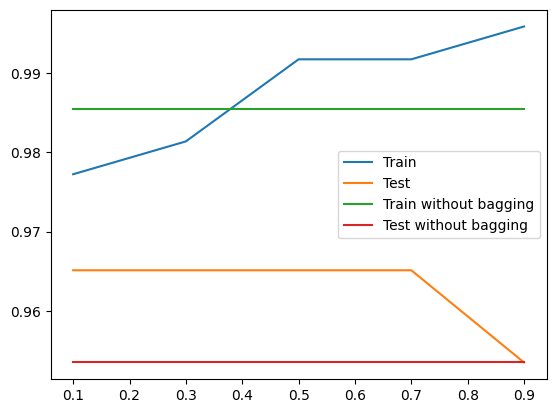

In [95]:
# Test on fraction of examples used to train each base learners

X_train, X_test, y_train, y_test = get_dataset('wdbc')
print(y_train)

log_regr = LogisticRegression(penalty=None, max_iter=5000)
log_regr.fit(X_train, y_train)
nobag_tr_acc = log_regr.score(X_train, y_train)
nobag_te_acc = log_regr.score(X_test, y_test)
print(nobag_tr_acc)
print(nobag_te_acc)


list_tr_acc = []
list_te_acc = []
for n_examples in list_n_examples:
    tr_acc, te_acc = bagging_log_regr(X_train, X_test, y_train, y_test, 10, n_examples)
    list_tr_acc.append(tr_acc)
    list_te_acc.append(te_acc)
print(list_tr_acc)
print(list_te_acc)
plot_acc_vs_n_examples(list_n_examples, list_tr_acc, list_te_acc, nobag_tr_acc, nobag_te_acc)

### Regularization (C) parameter

[0.9399585921325052, 0.9565217391304348, 0.9668737060041408, 0.9834368530020704, 0.9855072463768116, 0.989648033126294, 0.989648033126294, 0.9937888198757764]
[0.9418604651162791, 0.9651162790697675, 0.9651162790697675, 0.9651162790697675, 0.9651162790697675, 0.9651162790697675, 0.9651162790697675, 0.9651162790697675]
[0.9151138716356108, 0.9544513457556936, 0.9565217391304348, 0.9772256728778468, 0.9813664596273292, 0.9875776397515528, 0.9875776397515528, 0.9855072463768116]
[0.9069767441860465, 0.9534883720930233, 0.9418604651162791, 0.9651162790697675, 0.9651162790697675, 0.9651162790697675, 0.9651162790697675, 0.9651162790697675]


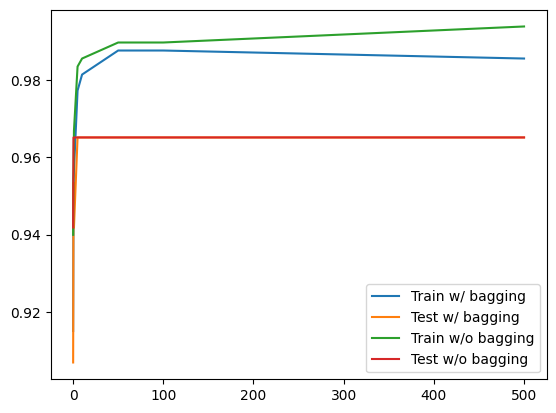

In [96]:
# Test on C

list_C = [0.1, 0.5, 1, 5, 10, 50, 100, 500]

X_train, X_test, y_train, y_test = get_dataset('wdbc')

list_nobag_tr_acc = []
list_nobag_te_acc = []
list_tr_acc = []
list_te_acc = []
for C in list_C:
    log_regr = LogisticRegression(penalty='l2', C=C, max_iter=5000)
    log_regr.fit(X_train, y_train)
    list_nobag_tr_acc.append(log_regr.score(X_train, y_train))
    list_nobag_te_acc.append(log_regr.score(X_test, y_test))
    tr_acc, te_acc = bagging_log_regr(X_train, X_test, y_train, y_test, 10, 0.5, regularization=C)
    list_tr_acc.append(tr_acc)
    list_te_acc.append(te_acc)
print(list_nobag_tr_acc)
print(list_nobag_te_acc)
print(list_tr_acc)
print(list_te_acc)
plot_acc_vs_C(list_C, list_tr_acc, list_te_acc, list_nobag_tr_acc, list_nobag_te_acc)

## Arrhythmia Dataset Experiments

### Base learners (n_estimators)

1.0
0.5441176470588235
[0.7291666666666666, 0.8723958333333334, 0.9036458333333334, 0.8776041666666666, 0.890625, 0.890625, 0.8880208333333334]
[0.5294117647058824, 0.6323529411764706, 0.6617647058823529, 0.6470588235294118, 0.6323529411764706, 0.6323529411764706, 0.6176470588235294]


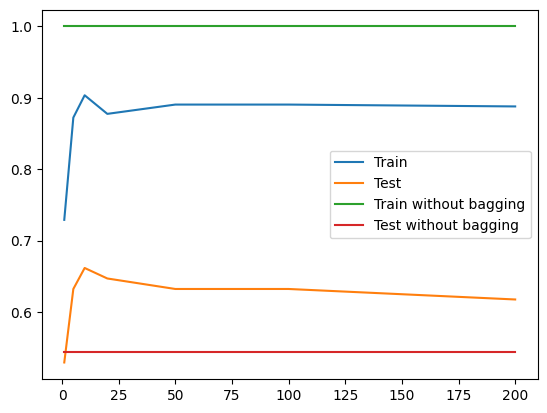

In [97]:
X_train, X_test, y_train, y_test = get_dataset('arrhythmia')

log_regr = LogisticRegression(penalty=None, max_iter=5000)
log_regr.fit(X_train, y_train)
nobag_tr_acc = log_regr.score(X_train, y_train)
nobag_te_acc = log_regr.score(X_test, y_test)
print(nobag_tr_acc)
print(nobag_te_acc)

list_tr_acc = []
list_te_acc = []
for n_models in list_n_models:
    tr_acc, te_acc = bagging_log_regr(X_train, X_test, y_train, y_test, n_models, 0.5)
    list_tr_acc.append(tr_acc)
    list_te_acc.append(te_acc)
print(list_tr_acc)
print(list_te_acc)
plot_acc_vs_n_models(list_n_models, list_tr_acc, list_te_acc, nobag_tr_acc, nobag_te_acc)


### Fraction of examples used to train each base learners

1.0
0.5441176470588235
[0.7083333333333334, 0.7916666666666666, 0.875, 0.8854166666666666, 0.9505208333333334]
[0.5882352941176471, 0.6617647058823529, 0.6470588235294118, 0.6323529411764706, 0.6470588235294118]


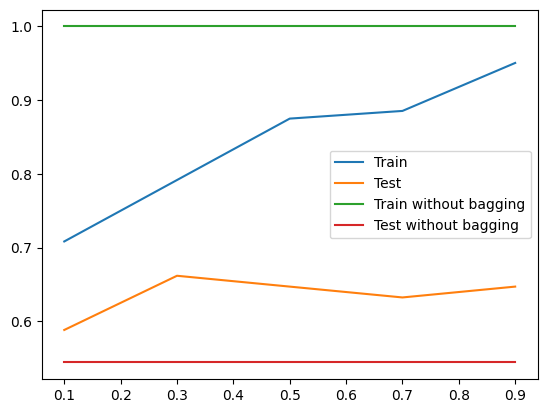

In [98]:
X_train, X_test, y_train, y_test = get_dataset('arrhythmia')

log_regr = LogisticRegression(penalty=None, max_iter=5000)
log_regr.fit(X_train, y_train)
nobag_tr_acc = log_regr.score(X_train, y_train)
nobag_te_acc = log_regr.score(X_test, y_test)
print(nobag_tr_acc)
print(nobag_te_acc)


list_tr_acc = []
list_te_acc = []
for n_examples in list_n_examples:
    tr_acc, te_acc = bagging_log_regr(X_train, X_test, y_train, y_test, 10, n_examples)
    list_tr_acc.append(tr_acc)
    list_te_acc.append(te_acc)
print(list_tr_acc)
print(list_te_acc)
plot_acc_vs_n_examples(list_n_examples, list_tr_acc, list_te_acc, nobag_tr_acc, nobag_te_acc)

### Regularization (C) parameter

[0.6640625, 0.8046875, 0.8359375, 0.9348958333333334, 0.9713541666666666, 0.9973958333333334, 1.0, 1.0]
[0.5882352941176471, 0.6323529411764706, 0.6323529411764706, 0.6470588235294118, 0.6617647058823529, 0.6176470588235294, 0.6029411764705882, 0.6029411764705882]
[0.5807291666666666, 0.7057291666666666, 0.75, 0.8203125, 0.8177083333333334, 0.8619791666666666, 0.8567708333333334, 0.875]
[0.5147058823529411, 0.5735294117647058, 0.6176470588235294, 0.6176470588235294, 0.6176470588235294, 0.6617647058823529, 0.6470588235294118, 0.6470588235294118]


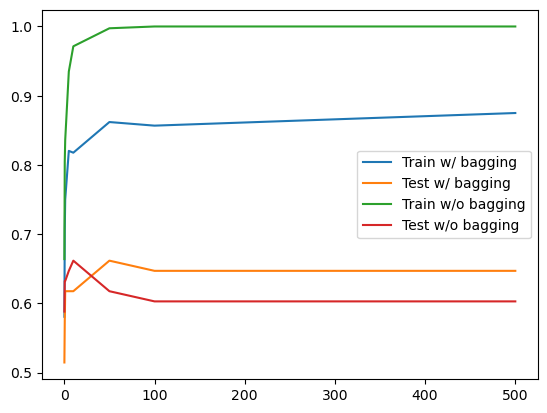

In [12]:
X_train, X_test, y_train, y_test = get_dataset('arrhythmia')

list_nobag_tr_acc = []
list_nobag_te_acc = []
list_tr_acc = []
list_te_acc = []
for C in list_C:
    log_regr = LogisticRegression(penalty='l2', C=C, max_iter=5000)
    log_regr.fit(X_train, y_train)
    list_nobag_tr_acc.append(log_regr.score(X_train, y_train))
    list_nobag_te_acc.append(log_regr.score(X_test, y_test))
    tr_acc, te_acc = bagging_log_regr(X_train, X_test, y_train, y_test, 10, 0.5, regularization=C)
    list_tr_acc.append(tr_acc)
    list_te_acc.append(te_acc)
print(list_nobag_tr_acc)
print(list_nobag_te_acc)
print(list_tr_acc)
print(list_te_acc)
plot_acc_vs_C(list_C, list_tr_acc, list_te_acc, list_nobag_tr_acc, list_nobag_te_acc)

# Darwin Dataset experiments

Setup logistic regression model without bagging

In [ ]:
darwin_log_regr = LogisticRegression(penalty=None, max_iter=5000)
darwin_log_regr.fit(darwin_data_x_train, darwin_data_y_train)
darwin_nobag_tr_acc = darwin_log_regr.score(darwin_data_x_train, darwin_data_y_train)
darwin_nobag_te_acc = darwin_log_regr.score(darwin_data_x_test, darwin_data_y_test)
print(f"Train accuracy: {darwin_nobag_tr_acc}\nTest Accuracy: {darwin_nobag_te_acc}")

Train accuracy: 1.0
Test Accuracy: 0.7407407407407407


Now we will use bagging to train the logistic regression model while running several experiments of hyperparameter tuning.

## N_estimators (aka number of base learners)

Train Accuracy:
[0.8979591836734694, 0.9455782312925171, 0.9591836734693877, 0.9659863945578231, 0.9591836734693877, 0.9659863945578231, 0.9727891156462585]
Test Accuracy:
[0.6296296296296297, 0.8518518518518519, 0.7407407407407407, 0.7407407407407407, 0.7777777777777778, 0.7777777777777778, 0.8148148148148148]


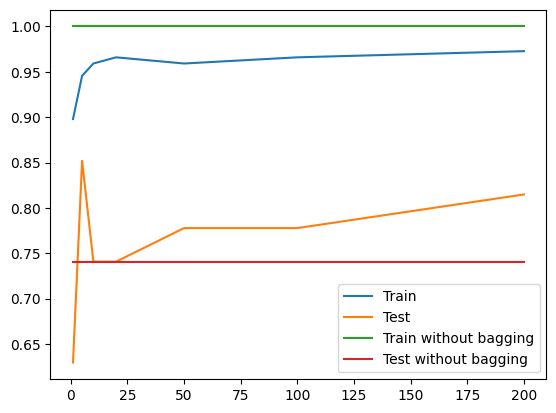

In [83]:
N_estimators_train_acc = []
N_estimators_test_acc = []
for estimator in list_n_models:
    tr_acc, te_acc = bagging_log_regr(darwin_data_x_train, darwin_data_x_test, darwin_data_y_train, darwin_data_y_test, estimator, 0.5)
    N_estimators_train_acc.append(tr_acc)
    N_estimators_test_acc.append(te_acc)
print(f"Train Accuracy:\n{N_estimators_train_acc}")
print(f"Test Accuracy:\n{N_estimators_test_acc}")

plot_acc_vs_n_models(list_n_models, N_estimators_train_acc, N_estimators_test_acc, darwin_nobag_tr_acc, darwin_nobag_te_acc)

## Testing fractional max_samples

Train Accuracy:
[0.7959183673469388, 0.9387755102040817, 0.9659863945578231, 0.9795918367346939, 0.9931972789115646]
Test Accuracy:
[0.7407407407407407, 0.7037037037037037, 0.7407407407407407, 0.8148148148148148, 0.8148148148148148]


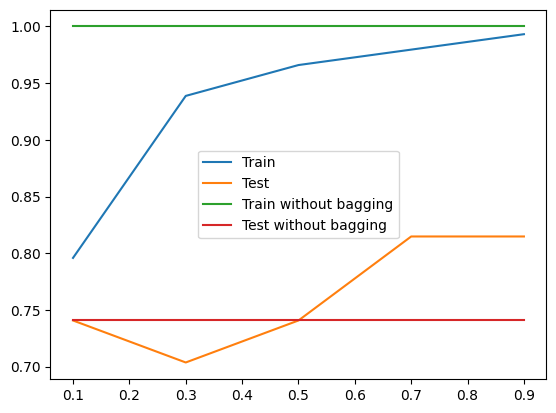

In [88]:
frac_max_samples_train_acc = []
frac_max_samples_test_acc = []
for n_examples in list_n_examples:
    tr_acc, te_acc = bagging_log_regr(darwin_data_x_train, darwin_data_x_test, darwin_data_y_train, darwin_data_y_test, 10, n_examples)
    frac_max_samples_train_acc.append(tr_acc)
    frac_max_samples_test_acc.append(te_acc)

print(f"Train Accuracy:\n{frac_max_samples_train_acc}")
print(f"Test Accuracy:\n{frac_max_samples_test_acc}")
plot_acc_vs_n_examples(list_n_examples, frac_max_samples_train_acc, frac_max_samples_test_acc, darwin_nobag_tr_acc, darwin_nobag_te_acc)

## Testing regularization parameter

Regularized Train Accuracy:
[0.9319727891156463, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Regulaized Test Accuracy:
[0.7407407407407407, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7407407407407407, 0.7407407407407407, 0.7407407407407407]
Regularized Train Accuracy with Bagging:
[0.8979591836734694, 0.9183673469387755, 0.9727891156462585, 0.9931972789115646, 0.9659863945578231, 0.9523809523809523, 0.9659863945578231, 0.9591836734693877]\Regularized Test Accuracy with Bagging:
[0.6666666666666666, 0.8148148148148148, 0.7777777777777778, 0.7407407407407407, 0.8148148148148148, 0.7037037037037037, 0.7777777777777778, 0.8148148148148148]


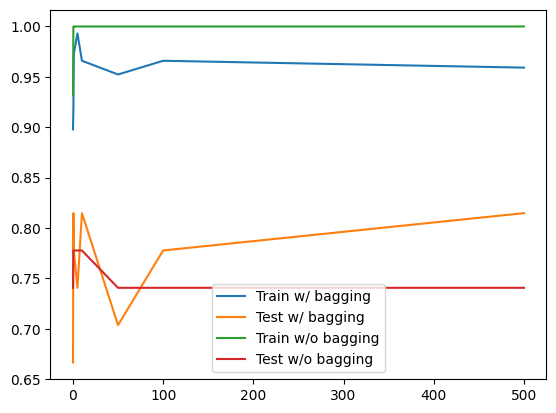

In [90]:
darwin_regularized_train_acc = []
darwin_regularized_test_acc = []
darwin_regularized_train_acc_bag = [] 
darwin_regularized_test_acc_bag = []
for c in list_C:
    cur_log_regr = LogisticRegression(penalty='l2', C=c, max_iter=5000)
    cur_log_regr.fit(darwin_data_x_train, darwin_data_y_train)
    darwin_regularized_train_acc.append(cur_log_regr.score(darwin_data_x_train, darwin_data_y_train))
    darwin_regularized_test_acc.append(cur_log_regr.score(darwin_data_x_test, darwin_data_y_test))
    cur_tr_acc_bag, cur_te_acc_bag = bagging_log_regr(darwin_data_x_train, darwin_data_x_test, darwin_data_y_train, darwin_data_y_test, 10, 0.5, regularization=c)
    darwin_regularized_train_acc_bag.append(cur_tr_acc_bag)
    darwin_regularized_test_acc_bag.append(cur_te_acc_bag)
print(f"Regularized Train Accuracy:\n{darwin_regularized_train_acc}\nRegulaized Test Accuracy:\n{darwin_regularized_test_acc}\nRegularized Train Accuracy with Bagging:\n{darwin_regularized_train_acc_bag}\Regularized Test Accuracy with Bagging:\n{darwin_regularized_test_acc_bag}")
plot_acc_vs_C(list_C, darwin_regularized_train_acc_bag, darwin_regularized_test_acc_bag, darwin_regularized_train_acc, darwin_regularized_test_acc)